# COVID-19 Lung CT Segmentation & Classification
This notebook aims to build image classifiers to determine whether a paitient is tested positive or negative for COVID-19 based on lung CT scan images. 
In doing so, a VGG-16 model and a 3-layer CNN model are used for classification.

Prior to the classification, the images are firstly segmented using K-means Clustering to enhance classification performance. Then, VGG-16 model is implemented and is trained on the raw and segmented images. Additionally, a 3-layer CNN model is trained on the segmented images.

The effect of image segmentation on image classification is discussed based on the performance of the VGG-16 model on both raw and segmented images. And the performances of the VGG-16 model and the 3-layer CNN model are compared and discusses. 

The dataset is sourced from 'COVID-19 Lung CT Scans' in Kaggle.<br>
https://www.kaggle.com/luisblanche/covidct

## 1. Import libraries

In [ ]:
!pip install pathlib

     |████████████████████████████████| 49 kB 1.7 MB/s 
  Created wheel for pathlib: filename=pathlib-1.0.1-py3-none-any.whl size=14346 sha256=8b440180b065c87ef23f1d87331aed4ace1acb77705bccf2cd1c25cd99026fae
  Stored in directory: /root/.cache/pip/wheels/6e/96/b8/10037fe231e23970bac58361d7c93571ab983a7bbc55e68550
Successfully built pathlib


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import cv2
from skimage.transform import pyramid_reduce, resize
from sklearn.model_selection import train_test_split
import keras,os
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Dropout
from keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


In [ ]:
np.random.seed(123)

## 2. Pre-processing

In [ ]:
# determine extension of images
## covid positive images
path = '../input/covidct/CT_COVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'positive image extensions: {ext_set}')

## covid negative images
path = '../input/covidct/CT_NonCOVID'
ext_set = set()
for child in Path(path).iterdir():
    ext = Path(child).suffix
    ext_set.add(ext)
print(f'negative image extensions: {ext_set}')

positive image extensions: {'.png'}
negative image extensions: {'.png', '.jpg'}


In [ ]:
# obtain list of images
## postive
path = '../input/covidct/CT_COVID'
pos_li = list(Path(path).glob('*.png'))

## negative
path = '../input/covidct/CT_NonCOVID'
neg_li = list(Path(path).glob('*.png'))
neg_li.extend(list(Path(path).glob('*.jpg')))

# display number of images
print(f'Postive images: {len(pos_li)}\nNegative images: {len(neg_li)}')

Postive images: 349
Negative images: 397


In [ ]:
# create numpy array placeholder for pixels with 1 channel (grey scale)
IMG_SIZE = 256
pos_data = np.empty((len(pos_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
neg_data = np.empty((len(neg_li), IMG_SIZE, IMG_SIZE, 1), dtype=np.float32)
# ^ float data type must be used to save precise pixel values

In [ ]:
# convert images to numpy arrays
## positive
for i, img_path in enumerate(sorted(pos_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    pos_data[i] = img
## negative
for i, img_path in enumerate(sorted(neg_li)):
    # load image
    img = cv2.imread(str(img_path))
    # convert BGR to RGB (since CV2 reads in BGR)
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    # resize image with 1 channel
    img = resize(img, output_shape=(IMG_SIZE, IMG_SIZE, 1), preserve_range=True)
    # save to x_data
    neg_data[i] = img

In [ ]:
# scale image arrays
pos_data /= 255
neg_data /= 255

## 3. Image segmentation with k-means clustering

In [ ]:
# define function to perform image segmentation with k-means clustering
def k_means(img_array_list, K, criteria, attempts):
    new_img_array_list = []
    for array in img_array_list:
        # flatten array into 2D
        img = array.reshape(-1,1) # reshape into new dimensions; -1 refers to unknown dimension and will depend on others
                                  # (-1,1) will result in 2D with 1 column and n rows where 1 column x n rows is equal to  
                                  # the original number of elements. ex) (10,10) = (5,20) > both with 100 elements
                                  # 1 column is used since it's gray-scale image (3 used for RGB)
        ret, label, center = cv2.kmeans(img, K, None, criteria, attempts, cv2.KMEANS_PP_CENTERS)
#         center = np.uint8(center)
        res = center[label.flatten()]
        result_image = res.reshape(256,256,1)
        new_img_array_list.append(result_image)
    return new_img_array_list

In [ ]:
# perform image segmentation
## define hyperparameters
criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
K = 2
attempts=10
## positive
pos_data_seg = k_means(pos_data, K, criteria, attempts)
## negative
neg_data_seg = k_means(neg_data, K, criteria, attempts)

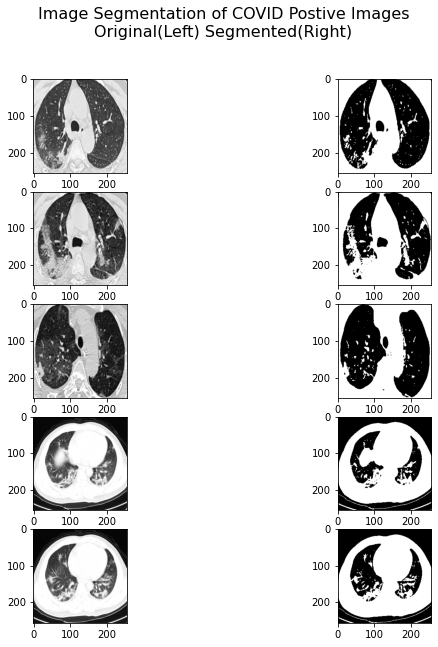

In [ ]:
# show results for positive scans
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, seg in enumerate(pos_data_seg):
    if i == 5:
        break
    ax[i, 0].imshow(pos_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle('Image Segmentation of COVID Postive Images\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()

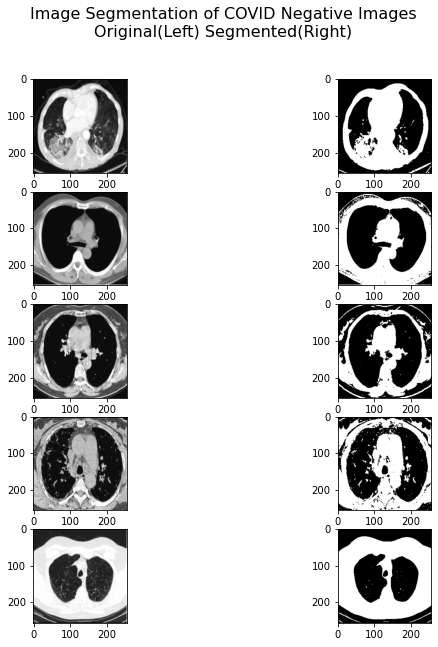

In [ ]:
# show results for negtive 
fig, ax = plt.subplots(5, 2, figsize=(10, 10))
for i, seg in enumerate(neg_data_seg):
    if i == 5:
        break
    ax[i, 0].imshow(neg_data[i].squeeze(), cmap='gray')
    ax[i, 1].imshow(seg.squeeze(), cmap='gray')
fig.suptitle('Image Segmentation of COVID Negative Images\nOriginal(Left) Segmented(Right)', fontsize=16)
plt.show()

## 4. Classification using VGG-16 model

In [ ]:
# split data into train-validation datasets with 20% validation proportion
x_data = pos_data_seg + neg_data_seg  # segmented images
x_data = np.array(x_data, dtype='float32')

y_data = [1]*len(pos_data_seg) + [0]*len(neg_data_seg)
y_data = np.array(y_data, dtype='float32')

x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.2)

In [ ]:
# callback options
"""
And EarlyStopping will stop the training if validation accuracy doesn't improve in 10 epochs.
"""
early = EarlyStopping(monitor='val_acc', min_delta=0, patience=10, verbose=1, mode='auto')

### 4.1. Classification with segmented images

In [ ]:
# build model
img_height = 256
img_width = 256

model = Sequential()
model.add(Conv2D(input_shape=(img_height,img_width,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
# model summary
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 256, 256, 64)      640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 256, 256, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 128, 128, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 128, 128, 128)     73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 128, 128, 128)     147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 64, 64, 128)       0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 64, 64, 256)       2

In [ ]:
# train model
batch_size = 16
epochs = 20
history = model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early])

Epoch 1/20
38/38 [==============================] - 7s 189ms/step - loss: 0.9094 - accuracy: 0.5268 - val_loss: 0.6919 - val_accuracy: 0.5267
Epoch 2/20
38/38 [==============================] - 6s 161ms/step - loss: 0.6944 - accuracy: 0.4899 - val_loss: 0.6919 - val_accuracy: 0.5267
Epoch 3/20
38/38 [==============================] - 6s 161ms/step - loss: 0.6916 - accuracy: 0.5336 - val_loss: 0.6917 - val_accuracy: 0.5267
Epoch 4/20
38/38 [==============================] - 6s 161ms/step - loss: 0.6925 - accuracy: 0.5336 - val_loss: 0.6917 - val_accuracy: 0.5267
Epoch 5/20
38/38 [==============================] - 6s 161ms/step - loss: 0.6920 - accuracy: 0.5336 - val_loss: 0.6928 - val_accuracy: 0.5267
Epoch 6/20
38/38 [==============================] - 6s 161ms/step - loss: 0.6921 - accuracy: 0.5336 - val_loss: 0.6921 - val_accuracy: 0.5267
Epoch 7/20
38/38 [==============================] - 6s 161ms/step - loss: 0.6918 - accuracy: 0.5336 - val_loss: 0.6917 - val_accuracy: 0.5267
Epoch 

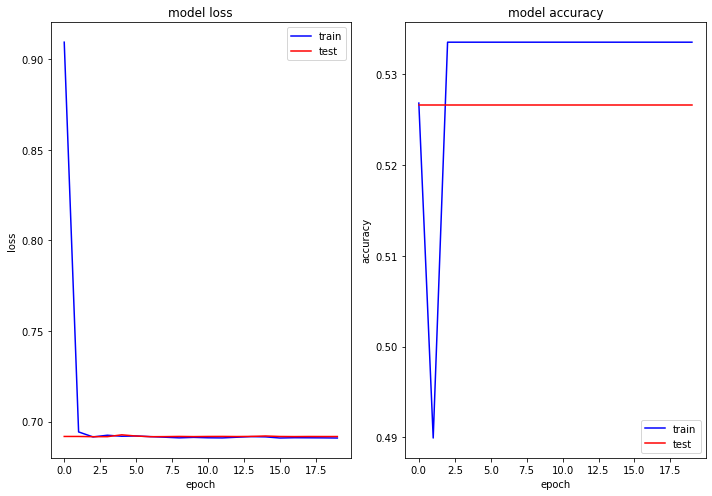

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history.history['loss'], 'b')
ax[0].plot(history.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history.history['accuracy'], 'b')
ax[1].plot(history.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

### 4.2. Classification with raw images

In [ ]:
# generate train and validation datasets from directories
"""
https://stackoverflow.com/questions/42443936/keras-split-train-test-set-when-using-imagedatagenerator
https://www.kaggle.com/dergel/cnn-on-covid-19-ct-lungs-scans
"""
DIR = '../input/covidct'

train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=5,
    width_shift_range=0.05,
    height_shift_range=0.05,
    shear_range=0.05,
    zoom_range=0.05,
    validation_split=0.2) 

train_generator = train_datagen.flow_from_directory(
    DIR,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="grayscale",
    subset='training') 

validation_generator = train_datagen.flow_from_directory(
    DIR, 
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='binary',
    color_mode="grayscale",
    subset='validation') 

Found 598 images belonging to 2 classes.
Found 148 images belonging to 2 classes.


In [ ]:
# rebuild model
img_height = 256
img_width = 256

model = Sequential()
model.add(Conv2D(input_shape=(img_height,img_width,1),filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(Conv2D(filters=64,kernel_size=(3,3),padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=128, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=256, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(Conv2D(filters=512, kernel_size=(3,3), padding="same", activation="relu"))
model.add(MaxPool2D(pool_size=(2,2),strides=(2,2)))
model.add(Flatten())
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=4096,activation="relu"))
model.add(Dense(units=1, activation="sigmoid"))
opt = Adam(lr=0.001)
model.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
# train model
history2 = model.fit_generator(train_generator, steps_per_epoch = train_generator.samples // batch_size,
        validation_data = validation_generator, validation_steps = validation_generator.samples // batch_size,
        epochs=epochs, callbacks=[early])

Epoch 1/20
37/37 [==============================] - 11s 294ms/step - loss: 0.8035 - accuracy: 0.4759 - val_loss: 0.6911 - val_accuracy: 0.5486
Epoch 2/20
37/37 [==============================] - 10s 281ms/step - loss: 0.6914 - accuracy: 0.5309 - val_loss: 0.6916 - val_accuracy: 0.5347
Epoch 3/20
37/37 [==============================] - 10s 283ms/step - loss: 0.6933 - accuracy: 0.5292 - val_loss: 0.6911 - val_accuracy: 0.5486
Epoch 4/20
37/37 [==============================] - 10s 276ms/step - loss: 0.6914 - accuracy: 0.5361 - val_loss: 0.6909 - val_accuracy: 0.5347
Epoch 5/20
37/37 [==============================] - 10s 281ms/step - loss: 0.6902 - accuracy: 0.5395 - val_loss: 0.6899 - val_accuracy: 0.5417
Epoch 6/20
37/37 [==============================] - 11s 301ms/step - loss: 0.6917 - accuracy: 0.5292 - val_loss: 0.6916 - val_accuracy: 0.5278
Epoch 7/20
37/37 [==============================] - 10s 280ms/step - loss: 0.6909 - accuracy: 0.5361 - val_loss: 0.6887 - val_accuracy: 0.5486

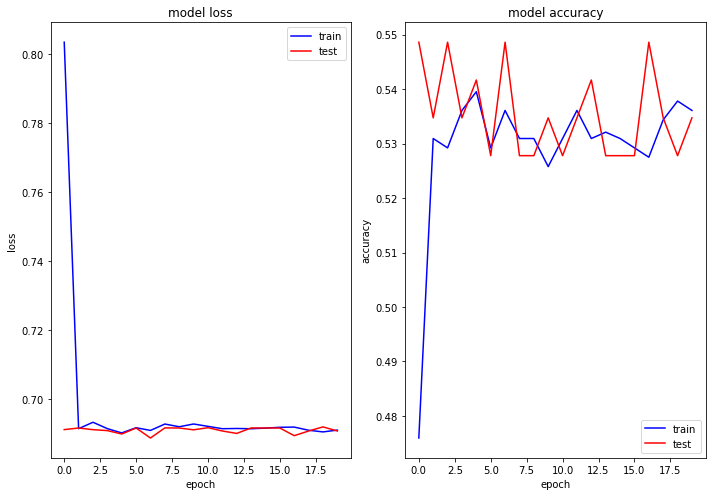

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history2.history['loss'], 'b')
ax[0].plot(history2.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history2.history['accuracy'], 'b')
ax[1].plot(history2.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## 5. Classification using simple 3-layer CNN model

In [ ]:
# build model
model2 = Sequential()
model2.add(Conv2D(32, 3, padding='same', activation='relu',input_shape=(img_height, img_width, 1))) 
model2.add(MaxPool2D()) 
model2.add(Conv2D(64, 5, padding='same', activation='relu'))
model2.add(MaxPool2D())
model2.add(Flatten())
model2.add(Dense(128, activation='relu'))
model2.add(Dense(1, activation='sigmoid'))
opt = Adam(lr=0.001)
model2.compile(optimizer=opt, loss=keras.losses.binary_crossentropy, metrics=['accuracy'])

In [ ]:
model2.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 256, 256, 32)      320       
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 128, 128, 32)      0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 128, 128, 64)      51264     
_________________________________________________________________
max_pooling2d_11 (MaxPooling (None, 64, 64, 64)        0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 262144)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 128)               33554560  
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
# train model
history3 = model2.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=epochs, batch_size=batch_size, callbacks=[early])

Epoch 1/20
38/38 [==============================] - 1s 37ms/step - loss: 1.3828 - accuracy: 0.5956 - val_loss: 0.6914 - val_accuracy: 0.4933
Epoch 2/20
38/38 [==============================] - 1s 26ms/step - loss: 0.6760 - accuracy: 0.5268 - val_loss: 0.6720 - val_accuracy: 0.5467
Epoch 3/20
38/38 [==============================] - 1s 26ms/step - loss: 0.6643 - accuracy: 0.5419 - val_loss: 0.6538 - val_accuracy: 0.5267
Epoch 4/20
38/38 [==============================] - 1s 26ms/step - loss: 0.6267 - accuracy: 0.6477 - val_loss: 0.6349 - val_accuracy: 0.6200
Epoch 5/20
38/38 [==============================] - 1s 26ms/step - loss: 0.4419 - accuracy: 0.7584 - val_loss: 0.7317 - val_accuracy: 0.6267
Epoch 6/20
38/38 [==============================] - 1s 26ms/step - loss: 0.2369 - accuracy: 0.8909 - val_loss: 0.8961 - val_accuracy: 0.6667
Epoch 7/20
38/38 [==============================] - 1s 26ms/step - loss: 0.1058 - accuracy: 0.9681 - val_loss: 1.1694 - val_accuracy: 0.6733
Epoch 8/20
38

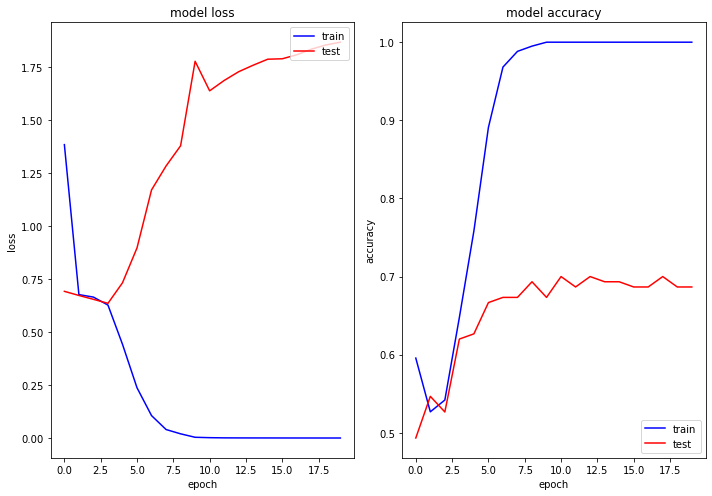

In [ ]:
# evaluate model
fig, ax = plt.subplots(1, 2, figsize=(10, 7))

# loss
ax[0].set_title('model loss')
ax[0].plot(history3.history['loss'], 'b')
ax[0].plot(history3.history['val_loss'], 'r')
ax[0].legend(['train', 'test'], loc='upper right')
ax[0].set_ylabel('loss')
ax[0].set_xlabel('epoch')

# accuracy 
ax[1].set_title('model accuracy')
ax[1].plot(history3.history['accuracy'], 'b')
ax[1].plot(history3.history['val_accuracy'], 'r')
ax[1].legend(['train', 'test'], loc='lower right')
ax[1].set_ylabel('accuracy')
ax[1].set_xlabel('epoch')

plt.tight_layout()
plt.show()

## 6. Comparison

### Effect of image segmentation
By looking at the performance of the VGG-16 model on both segmented images and raw images, the image segmentation allows smoother 
learning for models compared to the raw images. This is because image segmentation removes noises in images and helps the model
to learn better with less noises. However, this can oversimplify the images resulting in loss of features. 

### Comparison between deep and simple CNN models
The VGG-16 models shows stagnant training and testing accuracies between 0.52 and 0.55. In comparison, the 3-layer CNN model
achieves higher accuracies. The 3-layer CNN model learns better yet it overfits after 2 epochs. This difference may be due to 
gradient vanishing in VGG-16 model arising from its deep architecture. This can be improved by simplifying the model structure 
or altering activation function and optimisation (gradient descent) process. 

The deep structure of the VGG-16 model learns much more detailed features of the images than the simple 3-layer CNN model. And
the fact that VGG-16 model cannot distinguish between COVID positive and negative scan images may imply that there are not distinct differences between positive and negative images. And it may be that simple features such as edges and lines work better than the detailed features in this case. 

A use of pre-trained model could be tried in the future to examine if the feature maps learned from large datasets of other images could benefit the model to classify the CT scan images. 

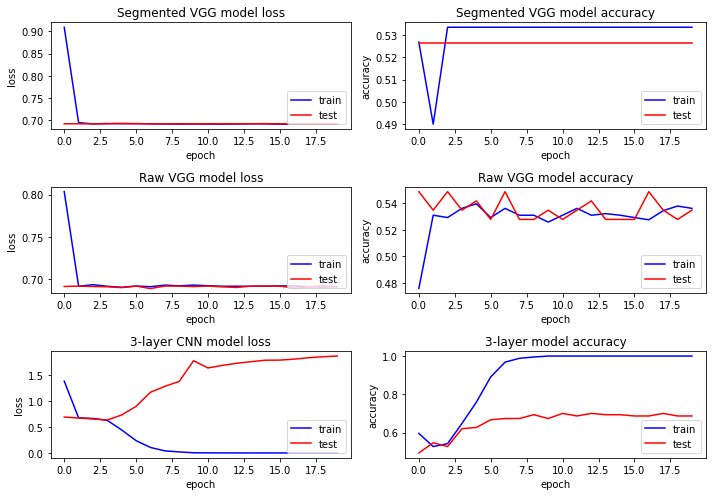

In [ ]:
# evaluate model
fig, ax = plt.subplots(3, 2, figsize=(10, 7))

# loss
ax[0,0].set_title('Segmented VGG model loss')
ax[0,0].plot(history.history['loss'], 'b')
ax[0,0].plot(history.history['val_loss'], 'r')
ax[0,0].legend(['train', 'test'], loc='lower right')
ax[0,0].set_ylabel('loss')
ax[0,0].set_xlabel('epoch')
ax[1,0].set_title('Raw VGG model loss')
ax[1,0].plot(history2.history['loss'], 'b')
ax[1,0].plot(history2.history['val_loss'], 'r')
ax[1,0].legend(['train', 'test'], loc='lower right')
ax[1,0].set_ylabel('loss')
ax[1,0].set_xlabel('epoch')
ax[2,0].set_title('3-layer CNN model loss')
ax[2,0].plot(history3.history['loss'], 'b')
ax[2,0].plot(history3.history['val_loss'], 'r')
ax[2,0].legend(['train', 'test'], loc='lower right')
ax[2,0].set_ylabel('loss')
ax[2,0].set_xlabel('epoch')

# accuracy 
ax[0,1].set_title('Segmented VGG model accuracy')
ax[0,1].plot(history.history['accuracy'], 'b')
ax[0,1].plot(history.history['val_accuracy'], 'r')
ax[0,1].legend(['train', 'test'], loc='lower right')
ax[0,1].set_ylabel('accuracy')
ax[0,1].set_xlabel('epoch')
ax[1,1].set_title('Raw VGG model accuracy')
ax[1,1].plot(history2.history['accuracy'], 'b')
ax[1,1].plot(history2.history['val_accuracy'], 'r')
ax[1,1].legend(['train', 'test'], loc='lower right')
ax[1,1].set_ylabel('accuracy')
ax[1,1].set_xlabel('epoch')
ax[2,1].set_title('3-layer model accuracy')
ax[2,1].plot(history3.history['accuracy'], 'b')
ax[2,1].plot(history3.history['val_accuracy'], 'r')
ax[2,1].legend(['train', 'test'], loc='lower right')
ax[2,1].set_ylabel('accuracy')
ax[2,1].set_xlabel('epoch')

plt.tight_layout()
plt.show()